##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rock, Paper & Scissors with TensorFlow Hub - TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%202/Exercise/TFLite_Week2_Exercise.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20Deployment/Course%202%20-%20TensorFlow%20Lite/Week%202/Exercise/TFLite_Week2_Exercise.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Setup

In [3]:
!pip uninstall tensorflow
!pip install tf-nightly

Uninstalling tensorflow-2.1.0rc1:
  Would remove:
    /tensorflow-2.1.0/python3.6/tensorflow-2.1.0rc1.dist-info/*
    /tensorflow-2.1.0/python3.6/tensorflow/*
    /tensorflow-2.1.0/python3.6/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.1.0rc1
  Using cached https://files.pythonhosted.org/packages/d6/84/759f5dd23fec8ba71952d97bcc7e2c9d7d63bdc582421f3cd4be845f0c98/gast-0.3.3-py2.py3-none-any.whl
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2


In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

TensorFlow 2.x selected.


In [2]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
# print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() else '\u2022 GPU Device Not Found. Running on CPU')
tf.config.list_physical_devices('GPU')

• Using TensorFlow Version: 2.2.0-dev20200123
• Using TensorFlow Hub Version:  0.7.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Select the Hub/TF2 Module to Use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [3]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data Preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"cats_vs_dog"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [0]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

# Go to the TensorFlow Dataset's website and search for the Rock, Paper, Scissors dataset and load it here
splits, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [0]:
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

Now shuffle and batch the data


In [0]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [0]:
# Prepare the examples by preprocessing the them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = train_examples.shuffle(num_examples//4).batch(BATCH_SIZE).map(format_image).prefetch(1)

validation_batches = validation_examples.batch(BATCH_SIZE).map(format_image).prefetch(1)

test_batches = test_examples.batch(1).map(format_image)

Inspect a batch

In [9]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

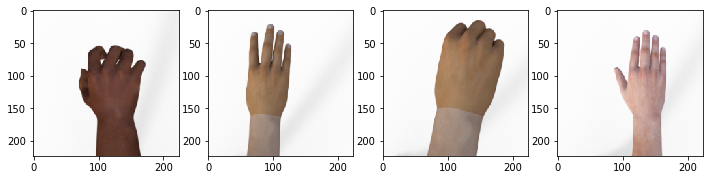

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    axs[i].imshow(image_batch[i])

plt.show()


## Defining the Model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [0]:
do_fine_tuning = False #@param {type:"boolean"}

In [0]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [13]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
#@title (Optional) Unfreeze some layers
NUM_LAYERS = 10 #@param {type:"slider", min:1, max:50, step:1}
      
if do_fine_tuning:
    feature_extractor.trainable = True
    
    for layer in model.layers[-NUM_LAYERS:]:
        layer.trainable = True

else:
    feature_extractor.trainable = False

## Training the Model

In [0]:
if do_fine_tuning:
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [16]:
EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
73/73 [==============================] - 13s 181ms/step - loss: 0.4150 - accuracy: 0.8585 - val_loss: 0.1349 - val_accuracy: 0.9786
Epoch 2/5
73/73 [==============================] - 9s 117ms/step - loss: 0.0957 - accuracy: 0.9923 - val_loss: 0.0703 - val_accuracy: 1.0000
Epoch 3/5
73/73 [==============================] - 9s 124ms/step - loss: 0.0522 - accuracy: 0.9991 - val_loss: 0.0497 - val_accuracy: 1.0000
Epoch 4/5
73/73 [==============================] - 9s 122ms/step - loss: 0.0348 - accuracy: 0.9991 - val_loss: 0.0320 - val_accuracy: 1.0000
Epoch 5/5
73/73 [==============================] - 8s 116ms/step - loss: 0.0251 - accuracy: 0.9996 - val_loss: 0.0257 - val_accuracy: 1.0000


## Export the Model

In [0]:
RPS_SAVED_MODEL = "rps_saved_model"

Export the SavedModel

In [18]:
# Use TensorFlow's SavedModel API to export the SavedModel from the trained Keras model

tf.saved_model.save(model, export_dir=RPS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: rps_saved_model/assets


INFO:tensorflow:Assets written to: rps_saved_model/assets


In [19]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [0]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [21]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Convert Using TFLite's Converter

In [0]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

In [0]:
# Post-training integer quantization

def representative_data_gen():
    for image_batch, label_batch in train_batches.take(1):
        yield [[image_batch[0]]]

converter.representative_dataset = representative_data_gen

In [0]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

converter.experimental_new_converter = True

In [0]:
# Use the tool to finally convert the model
tflite_model = converter.convert()

In [0]:
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

## Test the TFLite Model Using the Python Interpreter

In [0]:
# Load TFLite model and allocate tensors.
with open(tflite_model_file, 'rb') as fid:
    tflite_model = fid.read()
    
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [28]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

10it [00:09,  1.12it/s]


In [0]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    print(type(predicted_label), type(true_label))
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

<class 'numpy.int64'> <class 'numpy.int64'>


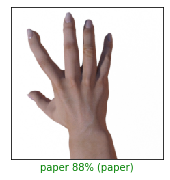

In [32]:
#@title Visualize the outputs { run: "auto" }
index = 6 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

<class 'numpy.int64'> <class 'numpy.int64'>


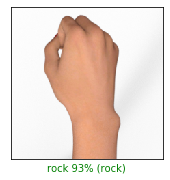

In [33]:
index = 3 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Create a file to save the labels.

In [0]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

If you are running this notebook in a Colab, you can run the cell below to download the model and labels to your local disk.

**Note**: If the files do not download when you run the cell, try running the cell a second time. Your browser might prompt you to allow multiple files to be downloaded. 

In [0]:
try:
    from google.colab import files
    files.download('converted_model.tflite')
    files.download('labels.txt')
except:
    pass

# Prepare the Test Images for Download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [0]:
!mkdir -p test_images

In [0]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [0]:
!ls test_images

paper_10.jpg  paper_44.jpg  rock_1.jpg	 rock_41.jpg	  scissors_32.jpg
paper_14.jpg  paper_46.jpg  rock_22.jpg  rock_45.jpg	  scissors_33.jpg
paper_19.jpg  paper_49.jpg  rock_23.jpg  rock_47.jpg	  scissors_35.jpg
paper_20.jpg  paper_6.jpg   rock_24.jpg  scissors_11.jpg  scissors_37.jpg
paper_25.jpg  paper_8.jpg   rock_27.jpg  scissors_13.jpg  scissors_43.jpg
paper_31.jpg  rock_0.jpg    rock_28.jpg  scissors_16.jpg  scissors_48.jpg
paper_38.jpg  rock_12.jpg   rock_30.jpg  scissors_21.jpg  scissors_4.jpg
paper_39.jpg  rock_15.jpg   rock_34.jpg  scissors_26.jpg  scissors_5.jpg
paper_40.jpg  rock_17.jpg   rock_36.jpg  scissors_29.jpg  scissors_7.jpg
paper_42.jpg  rock_18.jpg   rock_3.jpg	 scissors_2.jpg   scissors_9.jpg


In [0]:
!zip -qq rps_test_images.zip -r test_images/

If you are running this notebook in a Colab, you can run the cell below to download the Zip file with the images to your local disk. 

**Note**: If the Zip file does not download when you run the cell, try running the cell a second time.

In [0]:
try:
    files.download('rps_test_images.zip')
except:
    pass